In [17]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import psycopg2
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [18]:
def search(sql):
    import pandas as pd
    import psycopg2
    conn = psycopg2.connect(database="mimiciv", user="twccntuworkshop", 
                            password="ntuworkshop1210", host="211.73.81.172", 
                            port="5432")
    with conn.cursor() as cur:
        cur.execute(sql)
        name = [desc[0] for desc in cur.description]
        df = pd.DataFrame(cur.fetchall(),columns=name)
    return df

In [19]:
sql = """
 SELECT 
 so.stay_id,
 CASE WHEN MIN(so.pao2fio2ratio_vent) is null THEN 401 ELSE MIN(so.pao2fio2ratio_vent) END as pao2fio2ratio_vent,
 CASE WHEN MIN(so.pao2fio2ratio_novent) is null THEN 401 ELSE MIN(so.pao2fio2ratio_novent) END as pao2fio2ratio_novent,
 CASE WHEN MIN(so.platelet_min) is null THEN 151 ELSE MIN(so.platelet_min) END as platelet_min,
 CASE WHEN MAX(so.bilirubin_max) is null THEN 1.1 ELSE MAX(so.bilirubin_max) END as bilirubin_max,
 CASE WHEN MAX(so.rate_dopamine) is null THEN 4 ELSE MAX(so.rate_dopamine) END as rate_dopamine,
 CASE WHEN MAX(so.rate_epinephrine) is null THEN 4 ELSE MAX(so.rate_epinephrine) END as rate_epinephrine,
 CASE WHEN MAX(so.rate_norepinephrine) is null THEN 71 ELSE MAX(so.rate_norepinephrine) END as rate_norepinephrine,
 CASE WHEN MIN(so.gcs_min) is null THEN 15 ELSE MIN(so.gcs_min) END as gcs_min,
 CASE WHEN MAX(so.creatinine_max) is null THEN 1.1 ELSE MAX(so.creatinine_max) END as creatinine_max,
 CASE WHEN MAX(so.uo_24hr) is null THEN 201 ELSE MAX(so.uo_24hr) END as uo_24hr,
 MIN(se.sofa_score) as sofa_score
  FROM mimiciv_derived.sofa so
  JOIN mimiciv_derived.sepsis3 se
  ON so.stay_id = se.stay_id
  WHERE so.hr <24
  GROUP BY so.stay_id
"""

sofa = search(sql)

In [20]:
sofa.head()

,stay_id,pao2fio2ratio_vent,pao2fio2ratio_novent,platelet_min,bilirubin_max,rate_dopamine,rate_epinephrine,rate_norepinephrine,gcs_min,creatinine_max,uo_24hr,sofa_score
0,30000646,401.0,71.0,266.0,0.7,4.000000,4.0,71.000000,15.0,1.0,201.000000,3
1,30001446,401.0,401.0,36.0,6.4,5.004316,4.0,0.080021,15.0,2.7,1254.545455,8
2,30001555,401.0,401.0,35.0,19.6,4.000000,4.0,71.000000,13.0,1.1,2514.545455,8
3,30002415,401.0,240.0,124.0,1.1,4.000000,4.0,71.000000,15.0,0.8,201.000000,4
4,30002654,401.0,401.0,19.0,0.5,4.000000,4.0,0.250321,15.0,1.9,1456.155890,4


In [21]:
value = sofa.iloc[:,1:11]
label = sofa.sofa_score

In [22]:
from sklearn.model_selection import train_test_split
import xgboost as xgb
X_train, y_train, X_label, y_label = train_test_split(value, label)

dtrain = xgb.DMatrix(X_train, label=X_label)
dtest = xgb.DMatrix(y_train, label=y_label)

[0]	validation_0-logloss:0.68969	validation_0-roc_auc_score:0.81119
[1]	validation_0-logloss:0.68630	validation_0-roc_auc_score:0.81112
[2]	validation_0-logloss:0.68298	validation_0-roc_auc_score:0.81100
[3]	validation_0-logloss:0.67972	validation_0-roc_auc_score:0.81098
[4]	validation_0-logloss:0.67653	validation_0-roc_auc_score:0.82365
[5]	validation_0-logloss:0.67340	validation_0-roc_auc_score:0.82364
[6]	validation_0-logloss:0.67033	validation_0-roc_auc_score:0.82479
[7]	validation_0-logloss:0.66730	validation_0-roc_auc_score:0.82464
[8]	validation_0-logloss:0.66436	validation_0-roc_auc_score:0.82480
[9]	validation_0-logloss:0.66144	validation_0-roc_auc_score:0.82656
[10]	validation_0-logloss:0.65858	validation_0-roc_auc_score:0.82707
[11]	validation_0-logloss:0.65577	validation_0-roc_auc_score:0.82673
[12]	validation_0-logloss:0.65301	validation_0-roc_auc_score:0.82696
[13]	validation_0-logloss:0.65030	validation_0-roc_auc_score:0.82683
[14]	validation_0-logloss:0.64764	validation

<function matplotlib.pyplot.legend(*args, **kwargs)>

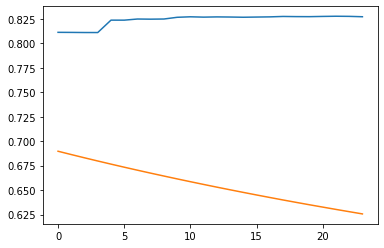

In [23]:
value = sofa.iloc[:,1:11]
label = sofa.sofa_score
label = np.array(label)
label[np.array(label) < 3] = 0
label[np.array(label) > 2] = 1

X_train, y_train, X_label, y_label = train_test_split(value, label)
from xgboost import XGBClassifier
from sklearn.metrics import mean_absolute_error, roc_auc_score
bst = XGBClassifier(n_estimators=200, x_depth=3, learning_rate=0.01, objective='binary:logistic', eval_metric=roc_auc_score, verbosity = 0, early_stopping_rounds=20)
bst.fit(X_train, X_label, eval_set=[(y_train, y_label)])
import matplotlib.pyplot as plt
acc = bst.evals_result_['validation_0']['roc_auc_score']
plt.plot(range(len(acc)), acc, label="acc")
loss = bst.evals_result_['validation_0']['logloss']
plt.plot(range(len(loss)),loss, label="label")
plt.legend

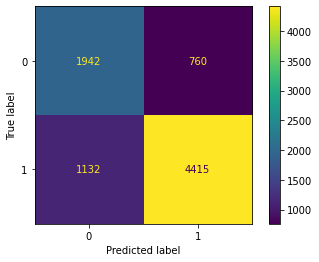

In [24]:
### from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(bst.predict(y_train), y_label, labels=bst.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=bst.classes_)
disp.plot()

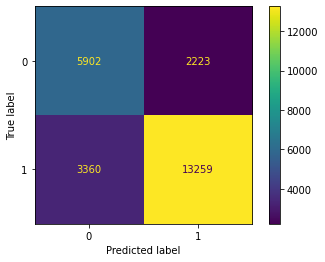

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(bst.predict(X_train), X_label, labels=bst.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=bst.classes_)
disp.plot()